In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tarfile

%load_ext autoreload
%autoreload 2
    
#runALU.ITER9000.PARALLEL1.ROUND1

NROUND=3
NPARALLEL=88


#NROUND=1
#NPARALLEL=1
df_dict = {
    'round': [], 
    'parallel': [], 
    'iter': [], 
    'kepler_container_bpf_block_irq_total': [], 
    'kepler_container_bpf_cpu_time_ms_total': [], 
    'kepler_container_bpf_net_rx_irq_total': [], 
    'kepler_container_bpf_net_tx_irq_total': [], 
    'kepler_container_bpf_page_cache_hit_total': [], 
    'kepler_container_cache_miss_total': [], 
    'dynamic_kepler_container_core_joules_total': [], 
    'idle_kepler_container_core_joules_total': [], 
    'kepler_container_cpu_cycles_total': [], 
    'kepler_container_cpu_instructions_total': [], 
    'dynamic_kepler_container_dram_joules_total': [], 
    'idle_kepler_container_dram_joules_total': [], 
    'dynamic_kepler_container_gpu_joules_total': [], 
    'idle_kepler_container_gpu_joules_total': [], 
    'dynamic_kepler_container_joules_total': [], 
    'idle_kepler_container_joules_total': [], 
    'dynamic_kepler_container_other_joules_total': [], 
    'idle_kepler_container_other_joules_total': [], 
    'dynamic_kepler_container_package_joules_total': [], 
    'idle_kepler_container_package_joules_total': [], 
    'dynamic_kepler_container_platform_joules_total': [], 
    'idle_kepler_container_platform_joules_total': [], 
    'kepler_container_task_clock_ms_total': [], 
    'dynamic_kepler_container_uncore_joules_total': [], 
    'idle_kepler_container_uncore_joules_total': []

}

def reset():
    for key in df_dict:
        df_dict[key] = []

/tmp/ipykernel_670810/3326743701.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
reset()
tar = tarfile.open("../results/results.tar.gz")

for round in range(0, NROUND):
    for para in range(1, NPARALLEL+1):
        fs = f"results/runALU.ITER9000.PARALLEL{para}.ROUND{round}.START"
        fe = f"results/runALU.ITER9000.PARALLEL{para}.ROUND{round}.END"
        df_dict['round'].append(round)
        df_dict['parallel'].append(para)
        df_dict['iter'].append(9000)

        fee=tar.extractfile(fe)
        content=fee.read()
        decoded_content = content.decode("utf-8")
        for line in decoded_content.split("\n"):
            if len(line) > 0 and line.startswith('#'):
                continue
            if "microbench" in line:
                name = (line.split(' ')[0]).split('{')[0]
                val = float(line.split(' ')[1])
                if "dynamic" in line:
                    df_dict[f"dynamic_{name}"].append(val)
                elif "idle" in line:
                    df_dict[f"idle_{name}"].append(val)
                else:
                    df_dict[name].append(val)
        
        fss=tar.extractfile(fs)
        content=fss.read()
        decoded_content = content.decode("utf-8")
        for line in decoded_content.split("\n"):
            if len(line) > 0 and line.startswith('#'):
                continue
            if "microbench" in line:
                name = (line.split(' ')[0]).split('{')[0]
                val = float(line.split(' ')[1])
                if "dynamic" in line:
                    df_dict[f"dynamic_{name}"][-1] = df_dict[f"dynamic_{name}"][-1] - val
                elif "idle" in line:
                    df_dict[f"idle_{name}"][-1] = df_dict[f"idle_{name}"][-1] - val
                else:
                    df_dict[name][-1] = df_dict[name][-1] - val
                


In [3]:
df = pd.DataFrame(df_dict)
dfnonzero = df.loc[:, (df != 0.0).any(axis=0)]

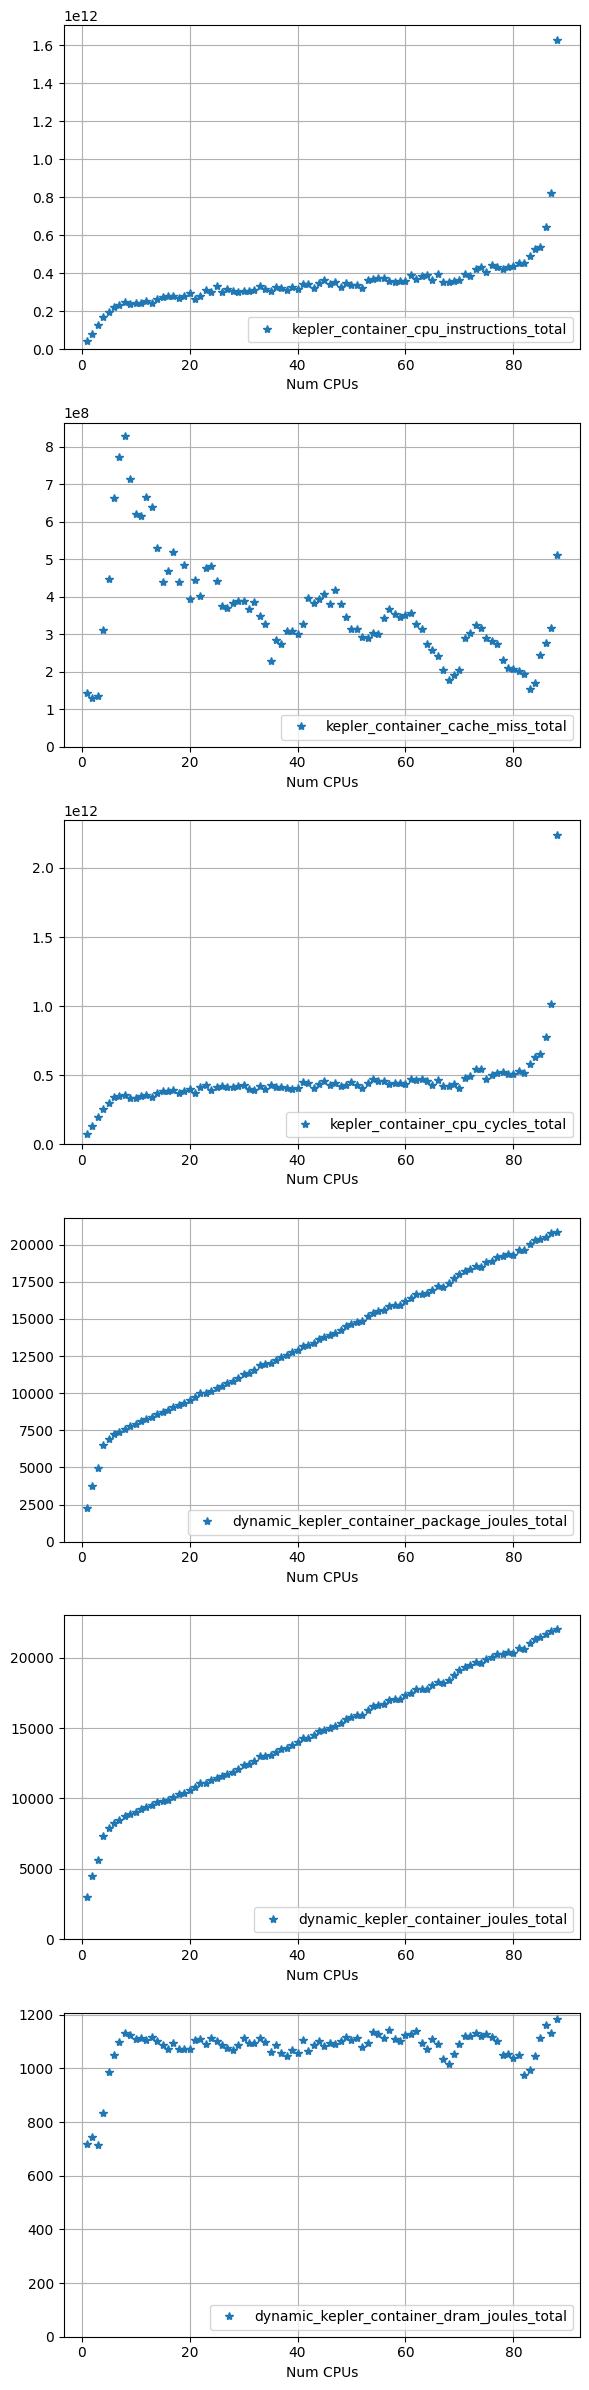

In [4]:
metrics = [
    'kepler_container_cpu_instructions_total',
    'kepler_container_cache_miss_total',
    'kepler_container_cpu_cycles_total',
    'dynamic_kepler_container_package_joules_total',
    'dynamic_kepler_container_joules_total',
    'dynamic_kepler_container_dram_joules_total',
]

fig, axs = plt.subplots(len(metrics), 1, figsize=(6, 24))
for i, ax in enumerate(axs.flat):
    m = df.groupby('parallel')[metrics[i]].mean()
    ax.errorbar(m.index, m, fmt="*", label=f"{metrics[i]}")
    ax.set_xlabel('Num CPUs')
    ax.set_ylim(bottom=0)
    ax.grid(True)
    ax.legend(loc='lower right')
plt.tight_layout()
plt.show()
